In [1]:
import os
import cv2

from scipy.stats import norm
from scipy.stats import multivariate_normal
from scipy.special import gamma,digamma,gammaln
from scipy.optimize import fminbound

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import math
import matplotlib.pyplot as plt

import numpy.matlib
from numpy.linalg import inv, det
import numpy as np

In [2]:
# dir_path = "C:/Users/kaidabcx/NCSU/CV/Project/1/"
dir_path = "C:/Users/chinm/Documents/Courses/Sem4/CV/Project/1/"

images_dir = "data/originalPics/"
fddb_file_path = "data/FDDB-folds/"
img_format = ".jpg"

output_dir = "data/output/"
bbox_fdd_folds = "bbox-FDDB-folds/"
bbox_faces_dir = "faces/"
bbox_non_faces_dir = "non_faces/"
face_dim = (20, 20)

model_path = "models/"

In [3]:
no_of_components = 5
dimensions_after_pca = 100

In [4]:
def get_files(path):
    files = []
    for root, subdirs, images in os.walk(path):
        if images:
            full_path_images = [os.path.join(root, image).replace("\\", "/") for image in images]
            files.extend(full_path_images)
    return files

In [5]:
def data_preparation():
    face_files = get_files(dir_path + output_dir + bbox_faces_dir)
    non_face_files = get_files(dir_path + output_dir + bbox_non_faces_dir)
    
    tr_face_data_images = face_files[:1000] 
    tr_non_face_data_images = non_face_files[:1000]
    
    te_face_data_images = face_files[1000:1100] 
    te_non_face_data_images = non_face_files[1000:1100]
    
    tr_face_data = [cv2.imread(img) for img in tr_face_data_images]
    tr_face_data = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(np.float64) for img in tr_face_data]
    tr_non_face_data = [cv2.imread(img) for img in tr_non_face_data_images]
    tr_non_face_data = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(np.float64) for img in tr_non_face_data]
    
    te_face_data = [cv2.imread(img) for img in te_face_data_images]
    te_face_data = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(np.float64) for img in te_face_data]
    
    te_non_face_data = [cv2.imread(img) for img in te_non_face_data_images]
    te_non_face_data = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(np.float64) for img in te_non_face_data]

    tr_face_data = np.array([cv2.normalize(i, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, \
                                           dtype=cv2.CV_32F).flatten() for i in tr_face_data])
    tr_non_face_data = np.array([cv2.normalize(i, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX,\
                                               dtype=cv2.CV_32F).flatten() for i in tr_non_face_data])
    
    te_face_data = np.array([cv2.normalize(i, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX,\
                                           dtype=cv2.CV_32F).flatten() for i in te_face_data])
    te_non_face_data = np.array([cv2.normalize(i, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX,\
                                               dtype=cv2.CV_32F).flatten() for i in te_non_face_data])
    
    tr_face_labels = np.array([1]*1000)
    tr_non_face_labels = np.array([0]*1000)
    
    te_face_labels = np.array([1]*100)
    te_non_face_labels = np.array([0]*100)
    
    return tr_face_data, tr_non_face_data, tr_face_labels, tr_non_face_labels, te_face_data, \
te_non_face_data, te_face_labels, te_non_face_labels

In [6]:
tr_face_data, tr_non_face_data, tr_face_labels, tr_non_face_labels, \
    te_face_data, te_non_face_data, te_face_labels, te_non_face_labels = data_preparation()
len(tr_face_data), len(tr_non_face_data), len(tr_face_labels), len(tr_non_face_labels), \
    len(te_face_data), len(te_non_face_data), len(te_face_labels), len(te_non_face_labels)

(1000, 1000, 1000, 1000, 100, 100, 100, 100)

In [7]:
def preprocessing(data):
    pca = PCA(n_components=100)
    pca.fit(data)
    pca_data = pca.transform(data)
    std_scaler = StandardScaler()
    std_scaler.fit(pca_data)
    std_data = std_scaler.transform(pca_data)
    return pca, std_data

In [8]:
pca_f, tr_f_data = preprocessing(tr_face_data)
pca_nf, tr_nf_data = preprocessing(tr_non_face_data)
_, te_f_data = preprocessing(te_face_data)
_, te_nf_data = preprocessing(te_non_face_data)

In [9]:
tr_f_data, tr_nf_data, te_f_data, te_nf_data = tr_f_data.T, tr_nf_data.T, te_f_data.T, te_nf_data.T

In [10]:
tr_f_data.shape, tr_nf_data.shape, te_f_data.shape, te_nf_data.shape

((100, 1000), (100, 1000), (100, 100), (100, 100))

In [11]:
def t_cost(v, e_of_h, e_of_log_of_h):
    length = len(e_of_h)
    t1 = (v/2) * np.log((v/2))
    t2 = gammaln((v/2))

    t_cost = 0
    for i in range(length):
       t3 = ((v/2) - 1) * e_of_log_of_h[i]
       t4 = (v/2) * e_of_h[i]
       t_cost += t1 - t2 + t3 - t4
    t_cost = -t_cost
    return t_cost

In [12]:
class T_Distribution():
    def __init__(self, data_size, mean, covs, v, image_dim=(20,20)):
        self.data_size = data_size
        self.mean = mean
        self.covs = covs
        self.v = v
        self.e_of_h = np.zeros(self.data_size)
        self.e_of_log_of_h = np.zeros(self.data_size)
        self.term = np.zeros(self.data_size)
        
    def update_v(self):
        v = fminbound(t_cost, 0, 10, args=(self.e_of_h, self.e_of_log_of_h)) 
        return v
        
    def EM(self, data):
        dimensions = data.shape[0]
        for row in range(self.data_size):
            temp = np.matmul((data[:,row].reshape(-1,1)-self.mean).T, inv(self.covs))
            term = np.matmul(temp, (data[:,row].reshape(-1,1)-self.mean))
            self.term[row] = term
            self.e_of_h = (self.v+dimensions) /(self.v+term)
            self.e_of_log_of_h = digamma((self.v+dimensions)/2) - np.log((self.v+term)/2)
                        
        self.mean = (np.sum(self.e_of_h * data, axis=1)/np.sum(self.e_of_h)).reshape(dimensions, 1)
        
        numerator = np.zeros((dimensions, dimensions))
        for i in range(self.data_size):
            temp = np.matmul((data[:,i].reshape(-1,1)-self.mean), (data[:,i].reshape(-1,1)-self.mean).T)
            numerator += self.e_of_h*temp
        self.covs = numerator/np.sum(self.e_of_h)
        self.covs = np.diag(np.diag(self.covs))
        
        self.v = self.update_v()
        
        for i in range(self.data_size):
            temp = np.matmul((data[:,row].reshape(-1,1)-self.mean).T, inv(self.covs))
            temp = np.matmul(temp, (data[:,row].reshape(-1,1)-self.mean))
            self.term[i] = term
            
    def predict(self, data, row):
        dimensions = self.mean.shape[0]
        term1 = gamma((self.v + dimensions)/2) / (((self.v * np.pi)** dimensions/2) *np.sqrt(det(self.covs))*gamma(self.v/2))
        term2 = np.matmul( (data[:,row].reshape(-1,1)-self.mean).T,inv(self.covs) )                                  
        term2 = np.matmul(term2,(data[:,row].reshape(-1,1) - self.mean))
        term = (1 + term2/self.v)
        prob = term1 * pow(term, -(self.v+dimensions)/2)
        return prob[0,0]
        

In [13]:
mean_f_data = np.mean(tr_f_data, axis=1)
mean_nf_data = np.mean(tr_nf_data, axis=1)

cov_f_data = np.cov(tr_f_data)
cov_f_data = np.diag(np.diagonal(cov_f_data), 0)
cov_nf_data = np.cov(tr_nf_data)
cov_nf_data = np.diag(np.diagonal(cov_nf_data), 0)

In [14]:
mean_f_data.shape, cov_f_data.shape

((100,), (100, 100))

In [15]:
t_dist_f = T_Distribution(1000, mean_f_data.reshape(-1,1), cov_f_data, v=5)
t_dist_nf = T_Distribution(1000, mean_nf_data.reshape(-1,1), cov_nf_data, v=5)

In [16]:
for i in range(1000):
    print("\nPerforming Iteration - {}".format(i))
    print("t_dist_for_face")
    t_dist_f.EM(tr_f_data)
    print("\ntdist_for_nonface")
    t_dist_nf.EM(tr_nf_data)


Performing Iteration - 0
t_dist_for_face

tdist_for_nonface

Performing Iteration - 1
t_dist_for_face

tdist_for_nonface

Performing Iteration - 2
t_dist_for_face

tdist_for_nonface

Performing Iteration - 3
t_dist_for_face

tdist_for_nonface

Performing Iteration - 4
t_dist_for_face

tdist_for_nonface

Performing Iteration - 5
t_dist_for_face

tdist_for_nonface

Performing Iteration - 6
t_dist_for_face

tdist_for_nonface

Performing Iteration - 7
t_dist_for_face

tdist_for_nonface

Performing Iteration - 8
t_dist_for_face

tdist_for_nonface

Performing Iteration - 9
t_dist_for_face

tdist_for_nonface

Performing Iteration - 10
t_dist_for_face

tdist_for_nonface

Performing Iteration - 11
t_dist_for_face

tdist_for_nonface

Performing Iteration - 12
t_dist_for_face

tdist_for_nonface

Performing Iteration - 13
t_dist_for_face

tdist_for_nonface

Performing Iteration - 14
t_dist_for_face

tdist_for_nonface

Performing Iteration - 15
t_dist_for_face

tdist_for_nonface

Performing Iterat


Performing Iteration - 132
t_dist_for_face

tdist_for_nonface

Performing Iteration - 133
t_dist_for_face

tdist_for_nonface

Performing Iteration - 134
t_dist_for_face

tdist_for_nonface

Performing Iteration - 135
t_dist_for_face

tdist_for_nonface

Performing Iteration - 136
t_dist_for_face

tdist_for_nonface

Performing Iteration - 137
t_dist_for_face

tdist_for_nonface

Performing Iteration - 138
t_dist_for_face

tdist_for_nonface

Performing Iteration - 139
t_dist_for_face

tdist_for_nonface

Performing Iteration - 140
t_dist_for_face

tdist_for_nonface

Performing Iteration - 141
t_dist_for_face

tdist_for_nonface

Performing Iteration - 142
t_dist_for_face

tdist_for_nonface

Performing Iteration - 143
t_dist_for_face

tdist_for_nonface

Performing Iteration - 144
t_dist_for_face

tdist_for_nonface

Performing Iteration - 145
t_dist_for_face

tdist_for_nonface

Performing Iteration - 146
t_dist_for_face

tdist_for_nonface

Performing Iteration - 147
t_dist_for_face

tdist_for_


tdist_for_nonface

Performing Iteration - 263
t_dist_for_face

tdist_for_nonface

Performing Iteration - 264
t_dist_for_face

tdist_for_nonface

Performing Iteration - 265
t_dist_for_face

tdist_for_nonface

Performing Iteration - 266
t_dist_for_face

tdist_for_nonface

Performing Iteration - 267
t_dist_for_face

tdist_for_nonface

Performing Iteration - 268
t_dist_for_face

tdist_for_nonface

Performing Iteration - 269
t_dist_for_face

tdist_for_nonface

Performing Iteration - 270
t_dist_for_face

tdist_for_nonface

Performing Iteration - 271
t_dist_for_face

tdist_for_nonface

Performing Iteration - 272
t_dist_for_face

tdist_for_nonface

Performing Iteration - 273
t_dist_for_face

tdist_for_nonface

Performing Iteration - 274
t_dist_for_face

tdist_for_nonface

Performing Iteration - 275
t_dist_for_face

tdist_for_nonface

Performing Iteration - 276
t_dist_for_face

tdist_for_nonface

Performing Iteration - 277
t_dist_for_face

tdist_for_nonface

Performing Iteration - 278
t_dist_f


Performing Iteration - 393
t_dist_for_face

tdist_for_nonface

Performing Iteration - 394
t_dist_for_face

tdist_for_nonface

Performing Iteration - 395
t_dist_for_face

tdist_for_nonface

Performing Iteration - 396
t_dist_for_face

tdist_for_nonface

Performing Iteration - 397
t_dist_for_face

tdist_for_nonface

Performing Iteration - 398
t_dist_for_face

tdist_for_nonface

Performing Iteration - 399
t_dist_for_face

tdist_for_nonface

Performing Iteration - 400
t_dist_for_face

tdist_for_nonface

Performing Iteration - 401
t_dist_for_face

tdist_for_nonface

Performing Iteration - 402
t_dist_for_face

tdist_for_nonface

Performing Iteration - 403
t_dist_for_face

tdist_for_nonface

Performing Iteration - 404
t_dist_for_face

tdist_for_nonface

Performing Iteration - 405
t_dist_for_face

tdist_for_nonface

Performing Iteration - 406
t_dist_for_face

tdist_for_nonface

Performing Iteration - 407
t_dist_for_face

tdist_for_nonface

Performing Iteration - 408
t_dist_for_face

tdist_for_


tdist_for_nonface

Performing Iteration - 524
t_dist_for_face

tdist_for_nonface

Performing Iteration - 525
t_dist_for_face

tdist_for_nonface

Performing Iteration - 526
t_dist_for_face

tdist_for_nonface

Performing Iteration - 527
t_dist_for_face

tdist_for_nonface

Performing Iteration - 528
t_dist_for_face

tdist_for_nonface

Performing Iteration - 529
t_dist_for_face

tdist_for_nonface

Performing Iteration - 530
t_dist_for_face

tdist_for_nonface

Performing Iteration - 531
t_dist_for_face

tdist_for_nonface

Performing Iteration - 532
t_dist_for_face

tdist_for_nonface

Performing Iteration - 533
t_dist_for_face

tdist_for_nonface

Performing Iteration - 534
t_dist_for_face

tdist_for_nonface

Performing Iteration - 535
t_dist_for_face

tdist_for_nonface

Performing Iteration - 536
t_dist_for_face

tdist_for_nonface

Performing Iteration - 537
t_dist_for_face

tdist_for_nonface

Performing Iteration - 538
t_dist_for_face

tdist_for_nonface

Performing Iteration - 539
t_dist_f


Performing Iteration - 654
t_dist_for_face

tdist_for_nonface

Performing Iteration - 655
t_dist_for_face

tdist_for_nonface

Performing Iteration - 656
t_dist_for_face

tdist_for_nonface

Performing Iteration - 657
t_dist_for_face

tdist_for_nonface

Performing Iteration - 658
t_dist_for_face

tdist_for_nonface

Performing Iteration - 659
t_dist_for_face

tdist_for_nonface

Performing Iteration - 660
t_dist_for_face

tdist_for_nonface

Performing Iteration - 661
t_dist_for_face

tdist_for_nonface

Performing Iteration - 662
t_dist_for_face

tdist_for_nonface

Performing Iteration - 663
t_dist_for_face

tdist_for_nonface

Performing Iteration - 664
t_dist_for_face

tdist_for_nonface

Performing Iteration - 665
t_dist_for_face

tdist_for_nonface

Performing Iteration - 666
t_dist_for_face

tdist_for_nonface

Performing Iteration - 667
t_dist_for_face

tdist_for_nonface

Performing Iteration - 668
t_dist_for_face

tdist_for_nonface

Performing Iteration - 669
t_dist_for_face

tdist_for_


tdist_for_nonface

Performing Iteration - 785
t_dist_for_face

tdist_for_nonface

Performing Iteration - 786
t_dist_for_face

tdist_for_nonface

Performing Iteration - 787
t_dist_for_face

tdist_for_nonface

Performing Iteration - 788
t_dist_for_face

tdist_for_nonface

Performing Iteration - 789
t_dist_for_face

tdist_for_nonface

Performing Iteration - 790
t_dist_for_face

tdist_for_nonface

Performing Iteration - 791
t_dist_for_face

tdist_for_nonface

Performing Iteration - 792
t_dist_for_face

tdist_for_nonface

Performing Iteration - 793
t_dist_for_face

tdist_for_nonface

Performing Iteration - 794
t_dist_for_face

tdist_for_nonface

Performing Iteration - 795
t_dist_for_face

tdist_for_nonface

Performing Iteration - 796
t_dist_for_face

tdist_for_nonface

Performing Iteration - 797
t_dist_for_face

tdist_for_nonface

Performing Iteration - 798
t_dist_for_face

tdist_for_nonface

Performing Iteration - 799
t_dist_for_face

tdist_for_nonface

Performing Iteration - 800
t_dist_f


Performing Iteration - 915
t_dist_for_face

tdist_for_nonface

Performing Iteration - 916
t_dist_for_face

tdist_for_nonface

Performing Iteration - 917
t_dist_for_face

tdist_for_nonface

Performing Iteration - 918
t_dist_for_face

tdist_for_nonface

Performing Iteration - 919
t_dist_for_face

tdist_for_nonface

Performing Iteration - 920
t_dist_for_face

tdist_for_nonface

Performing Iteration - 921
t_dist_for_face

tdist_for_nonface

Performing Iteration - 922
t_dist_for_face

tdist_for_nonface

Performing Iteration - 923
t_dist_for_face

tdist_for_nonface

Performing Iteration - 924
t_dist_for_face

tdist_for_nonface

Performing Iteration - 925
t_dist_for_face

tdist_for_nonface

Performing Iteration - 926
t_dist_for_face

tdist_for_nonface

Performing Iteration - 927
t_dist_for_face

tdist_for_nonface

Performing Iteration - 928
t_dist_for_face

tdist_for_nonface

Performing Iteration - 929
t_dist_for_face

tdist_for_nonface

Performing Iteration - 930
t_dist_for_face

tdist_for_

Visualizing Mean


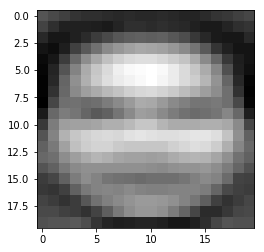

Visualizing Covariance


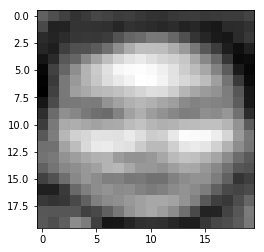

True

In [17]:
print("Visualizing Mean")
mean_f_img = np.dot(t_dist_f.mean[:,0], pca_f.components_) + pca_f.mean_
mean_f_img = np.array(mean_f_img).astype('uint8')
mean_f_img = np.reshape(mean_f_img,(20,20))
plt.imshow(mean_f_img, cmap="gray")
plt.show()
print("Visualizing Covariance")
cov_f_img = np.diagonal(t_dist_f.covs)
cov_f_img = np.matmul(np.log(cov_f_img), pca_f.components_) + pca_f.mean_
cov_f_img =  cov_f_img.reshape(20,20)
plt.imshow(cov_f_img, cmap='gray')
plt.show()


cv2.imwrite(dir_path + model_path + "T_Distribution/" + "Mean_Face_Image.jpg", mean_f_img)
cv2.imwrite(dir_path + model_path + "T_Distribution/" + "Cov_Face_Image.jpg", cov_f_img) 

cv2.imwrite(dir_path + model_path + "T_Distribution/" + "Mean_Face_Image_Resize.jpg", \
            cv2.resize(mean_f_img, (60,60)))
cv2.imwrite(dir_path + model_path + "T_Distribution/" + "Cov_Face_Image_Resize.jpg", \
            cv2.resize(cov_f_img, (60,60)))

Visualizing Mean


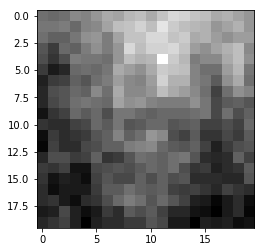

Visualizing Covariance


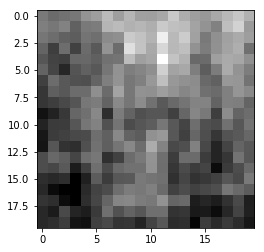

True

In [18]:
print("Visualizing Mean")
mean_nf_img = np.dot(t_dist_nf.mean[:,0], pca_nf.components_) + pca_nf.mean_
mean_nf_img = np.array(mean_nf_img).astype('uint8')
mean_nf_img = np.reshape(mean_nf_img,(20,20))
plt.imshow(mean_nf_img, cmap="gray")
plt.show()


print("Visualizing Covariance")
cov_nf_img = np.diagonal(t_dist_nf.covs)
cov_nf_img = np.dot(np.log(cov_nf_img), pca_nf.components_) + pca_nf.mean_
cov_nf_img = cov_nf_img.reshape(20,20)
plt.imshow(cov_nf_img, cmap='gray')
plt.show()

cv2.imwrite(dir_path + model_path + "T_Distribution/" + "Mean_Non_Face_Image.jpg", mean_nf_img)
cv2.imwrite(dir_path + model_path + "T_Distribution/" + "Cov_Non_Face_Image.jpg", cov_nf_img) 

cv2.imwrite(dir_path + model_path + "T_Distribution/" + "Mean_Non_Face_Image_Resize.jpg", \
            cv2.resize(mean_nf_img, (60,60)))
cv2.imwrite(dir_path + model_path + "T_Distribution/" + "Cov_Non_Face_Image_Resize.jpg", \
            cv2.resize(cov_nf_img, (60,60)))

In [19]:
pred_f_fdata, pred_f_nfdata, pred_nf_fdata, pred_nf_nfdata = [], [], [], []

for i in range(100):
    pred_f_fdata.append(t_dist_f.predict(te_f_data, i))
    pred_f_nfdata.append(t_dist_f.predict(te_nf_data, i))
    
    pred_nf_fdata.append(t_dist_nf.predict(te_f_data, i))
    pred_nf_nfdata.append(t_dist_nf.predict(te_nf_data, i))

pred_f_fdata = np.array(pred_f_fdata)
pred_f_nfdata = np.array(pred_f_nfdata)
pred_nf_fdata = np.array(pred_nf_fdata)
pred_nf_nfdata = np.array(pred_nf_nfdata)

pred_f_fdata = pred_f_fdata/(pred_f_fdata+pred_f_nfdata)
pred_f_nfdata = pred_f_nfdata/(pred_f_fdata+pred_f_nfdata)
pred_nf_fdata = pred_nf_fdata/(pred_nf_fdata+pred_nf_nfdata)
pred_nf_nfdata = pred_nf_nfdata/(pred_nf_fdata+pred_nf_nfdata)

In [20]:
pred_f_labels = [1 if pred_f_fdata[i]>pred_nf_fdata[i] else 0 for i in range(100)]
pred_nf_labels = [1 if pred_f_nfdata[i]>pred_nf_nfdata[i] else 0 for i in range(100)]

In [21]:
pred_labels = pred_f_labels + pred_nf_labels
true_labels = [1]*100 + [0]*100

In [22]:
def confusion_matrix(y_actual, y_pred):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_pred)): 
        if y_actual[i]==y_pred[i]==1:
           TP += 1
        if y_pred[i]==1 and y_actual[i]!=y_pred[i]:
           FP += 1
        if y_actual[i]==y_pred[i]==0:
           TN += 1
        if y_pred[i]==0 and y_actual[i]!=y_pred[i]:
           FN += 1

    return(TP, FP, TN, FN)

In [23]:
TP, FP, TN, FN = confusion_matrix(true_labels, pred_labels)

In [24]:
fpr =  FP/(FP+TN)
fnr = FN/(TP+FN)
mis_class_rate = (FP + FN)/200
print("False Positive Rate: {}".format(fpr))
print("False Negative Rate: {}".format(fnr))
print("Mis Classification Rate: {}".format(mis_class_rate))

False Positive Rate: 0.0
False Negative Rate: 0.49
Mis Classification Rate: 0.245


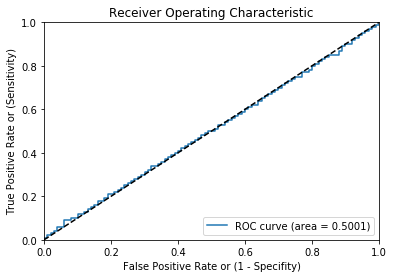

In [25]:
fpr, tpr, threshold = roc_curve([1]*100 + [0]*100, np.append(pred_f_fdata, pred_nf_fdata))
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig(dir_path + model_path + "T_Distribution/" + "T_Distribution_ROC_Curve.png")